In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [2]:
# Prevent GPU memory errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
directory = 'img_align_celeba'

# Load Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=directory, 
    color_mode='rgb',
    batch_size=128, 
    image_size=(32,32), 
    label_mode=None,
    shuffle=True, 
    seed=42
)

# Normalize the data
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files.


In [4]:
# Show a Grid of Images
from mpl_toolkits.axes_grid1 import ImageGrid

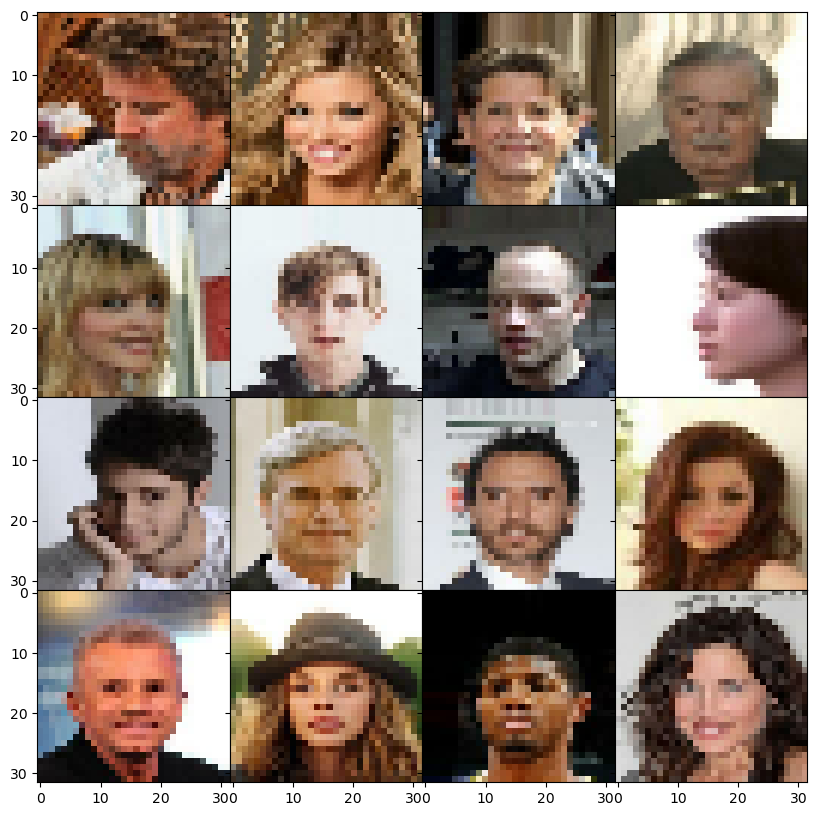

In [5]:
it = iter(dataset)
one_batch = next(it).numpy()
images = one_batch[:16, :, :, :]

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(4,4), axes_pad=0)
for ax, im in zip(grid, images):
    ax.imshow(im)
plt.show()

GANs-> Generartive Adversarial Network
Generator, Disc.
Disc.-> Image Classification Task
Latent-> Noise

In [6]:
# Generator Model
def generator_model(z_dim=100):
    gen_input = tf.keras.layers.Input(shape=(z_dim,))
    x = tf.keras.layers.Dense(8 * 8 * 128)(gen_input)
    x = tf.keras.layers.Reshape((8, 8, 128))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(3, 3, activation='tanh', padding='same')(x)
    
    return tf.keras.models.Model(gen_input, x)

gen_model = generator_model()

In [7]:
# Discriminator Model
def discriminator_model():
    disc_input = tf.keras.layers.Input(shape=(32, 32, 3))
    x = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same')(disc_input)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    return tf.keras.models.Model(disc_input, x)

In [8]:

disc_model = discriminator_model()


In [9]:
disc_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# GAN Model
disc_model.trainable = False
z_dim = 100
model_input = tf.keras.layers.Input(shape=(z_dim,))
model_output = disc_model(gen_model(model_input))
gan_model = tf.keras.models.Model(model_input, model_output)
gan_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy')

In [11]:
# Training Functions
def train_discriminator(batch, batch_size):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    batch_numpy = batch.numpy()  # Convert to NumPy before training
    disc_model.train_on_batch(batch_numpy, valid)
    
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    gen_images = gen_model.predict(noise, verbose=0)
    disc_model.train_on_batch(gen_images, fake)

def train_generator(batch_size):
    valid = np.ones((batch_size, 1))
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    gan_model.train_on_batch(noise, valid)

In [ ]:

# Training Loop
PATH = 'generate_face'
os.makedirs(PATH, exist_ok=True)
epochs = 100
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    for i, batch in enumerate(dataset):
        batch_size = batch.shape[0]
        train_discriminator(batch, batch_size)
        train_generator(batch_size)
        if i % 100 == 0:
            print(f'Batch {i}')

print("Training Completed!")


Epoch 1/100


C:\Users\jivan\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Batch 0
Batch 100
Batch 200
